In [1]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.append("../")
import macrophages_analysis
import scikitplot as skplt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Data import

In [2]:
preprocessed_data_path = '../../20x_datasets/Preprocessed_data/'

# make merged CD86+CD206 datasets
nucleus_dataset_p4g4_206 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD206_P4G4_nucleus_dataset.csv')
nucleus_dataset_p4g4_86 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD86_P4G4_nucleus_dataset.csv')
nucleus_dataset_p4g4 = nucleus_dataset_p4g4_206.merge(nucleus_dataset_p4g4_86, how='outer')

nucleus_dataset_smooth_206 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD206_Smooth_nucleus_dataset.csv')
nucleus_dataset_smooth_86 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD86_Smooth_nucleus_dataset.csv')
nucleus_dataset_smooth = nucleus_dataset_smooth_206.merge(nucleus_dataset_smooth_86, how='outer')

nucleus_dataset_tcps_206 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD206_TCPS_nucleus_dataset.csv')
nucleus_dataset_tcps_86 = pd.read_csv(preprocessed_data_path + 'clean_20x_CD86_TCPS_nucleus_dataset.csv')
nucleus_dataset_tcps = nucleus_dataset_tcps_206.merge(nucleus_dataset_tcps_86, how='outer')

all_surfaces = pd.concat([nucleus_dataset_p4g4, nucleus_dataset_smooth, nucleus_dataset_tcps])
all_surfaces_206 = pd.concat([nucleus_dataset_p4g4_206, nucleus_dataset_smooth_206, nucleus_dataset_tcps_206])
all_surfaces_86 = pd.concat([nucleus_dataset_p4g4_86, nucleus_dataset_smooth_86, nucleus_dataset_tcps_86])

all_surfaces = all_surfaces[all_surfaces['CellType'] != 'NT']
all_surfaces_206 = all_surfaces_206[all_surfaces_206['CellType'] != 'NT']
all_surfaces_86 = all_surfaces_86[all_surfaces_86['CellType'] != 'NT']

# 20x CD86+CD206
## 20x_CD86+CD206_all_surfaces_all_features_M1-M2

## Train XGBClassifier

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9320264525271611
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.9245454211726842
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.9318345129317634


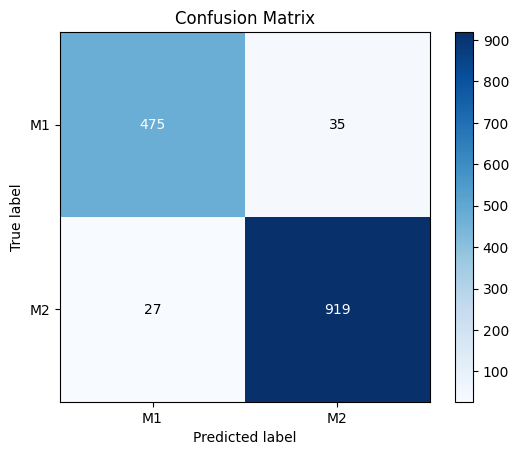

In [3]:
all_surfaces = all_surfaces[all_surfaces['CellType'] != 'NT']
pipe, test_data = macrophages_analysis.make_nucleus_classifier(all_surfaces, confusion_matrix=True, no_NT=True)

## One-vs-Rest multiclass ROC

AUC:  0.9905961115947437


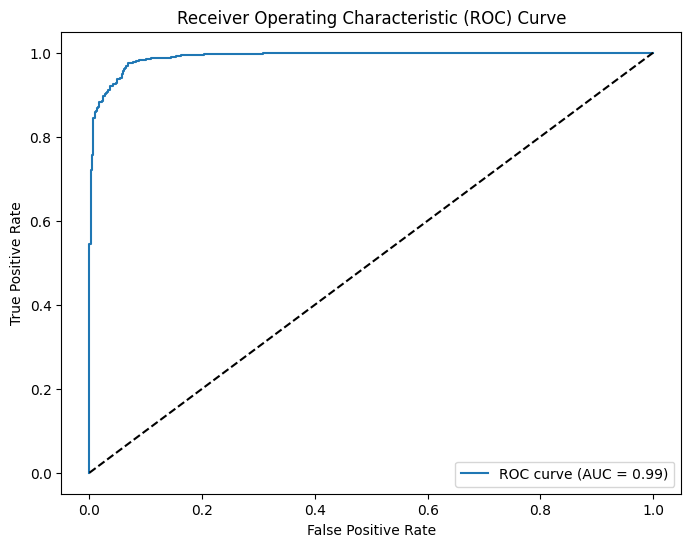

In [4]:
actual_labels = test_data[1]
predicted_probabilities = pipe.predict_proba(test_data[0])[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probabilities)

# Compute AUC
auc = roc_auc_score(actual_labels, predicted_probabilities)
print("AUC: ", auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

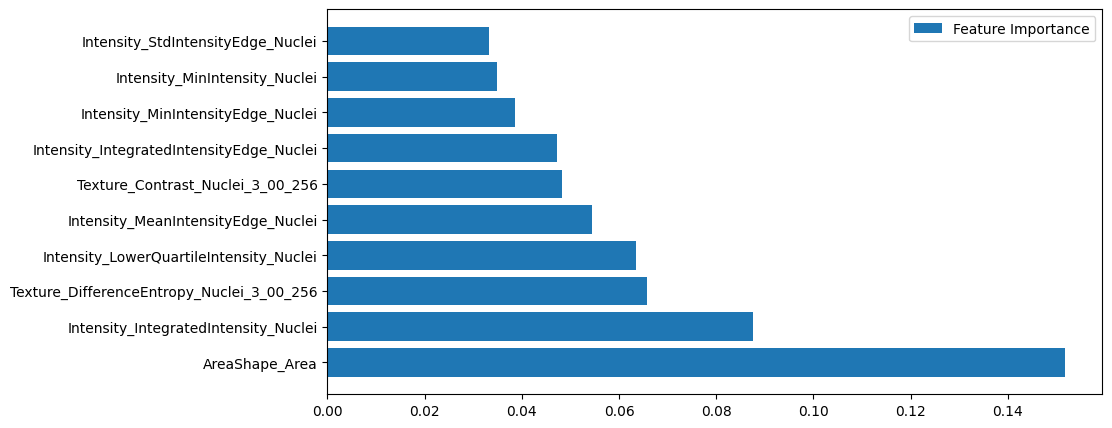

In [5]:
important_features = macrophages_analysis.get_best_features(pipe, all_surfaces.drop('CellType', axis=1), 10)
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(important_features['Feature'], important_features['Importance'], label='Feature Importance')
ax.legend()

# 20x_CD86_model_CD206_data_all_surfaces_all_features_M1-M2

In [6]:
pipe, test_data = macrophages_analysis.make_nucleus_classifier(all_surfaces_86, confusion_matrix=False, no_NT=True)

X_nucleus = all_surfaces_206.drop('CellType', axis=1)
y_nucleus = all_surfaces_206['CellType']

label_encoder = LabelEncoder()
y_nucleus = label_encoder.fit_transform(y_nucleus)

y_pred = pipe.predict(X_nucleus)
test_data_206 = (X_nucleus, y_nucleus)

class_proba = pipe.predict_proba(X_nucleus)

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9392405063291138
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.9366706490394181
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.9390898760582853


0.76953125
0.7288550119114351
0.7742962709087458


([<matplotlib.axis.YTick at 0x254f6a29f90>,
 [Text(0, 0, 'M1'), Text(0, 1, 'M2')])

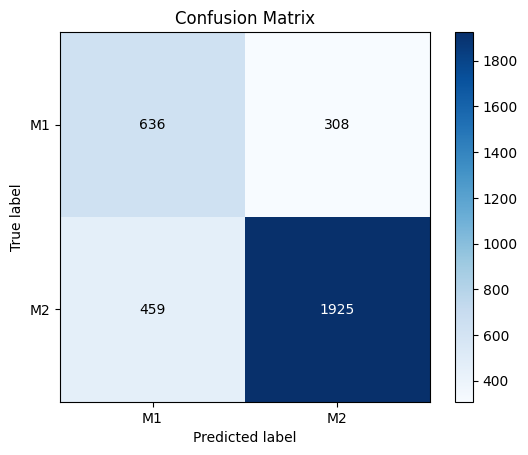

In [7]:
y_pred = class_proba[:,1] >= 0.2

accuracy = accuracy_score(y_nucleus, y_pred)
f1_macro = f1_score(y_nucleus, y_pred, average='macro')
f1_weighted = f1_score(y_nucleus, y_pred, average='weighted')
print(accuracy)
print(f1_macro)
print(f1_weighted)

skplt.metrics.plot_confusion_matrix(y_nucleus, y_pred, normalize=False, title='Confusion Matrix')
plt.xticks(range(2),['M1', 'M2'])
plt.yticks(range(2),['M1', 'M2'])

AUC:  0.8366140175321352


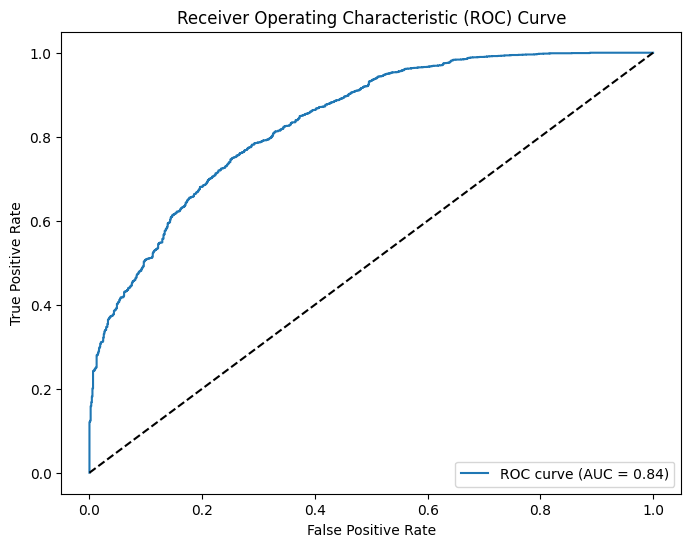

In [8]:
actual_labels = test_data_206[1]
predicted_probabilities = pipe.predict_proba(test_data_206[0])[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probabilities)

# Compute AUC
auc = roc_auc_score(actual_labels, predicted_probabilities)
print("AUC: ", auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# 20x_CD206_model_CD86_data_all_surfaces_all_features_M1-M2

In [9]:
pipe, test_data = macrophages_analysis.make_nucleus_classifier(all_surfaces_206, confusion_matrix=False, no_NT=True)

X_nucleus = all_surfaces_86.drop('CellType', axis=1)
y_nucleus = all_surfaces_86['CellType']

label_encoder = LabelEncoder()
y_nucleus = label_encoder.fit_transform(y_nucleus)

y_pred = pipe.predict(X_nucleus)
test_data = (X_nucleus, y_nucleus)

class_probabilities = pipe.predict_proba(X_nucleus)

Mean accuracy of XGBClassifier (10-fold cross-validation) 0.9639981908638624
Mean f1-macro of XGBClassifier (10-fold cross-validation) 0.9533433434005809
Mean f1_weighted of XGBClassifier (10-fold cross-validation) 0.963276815319329


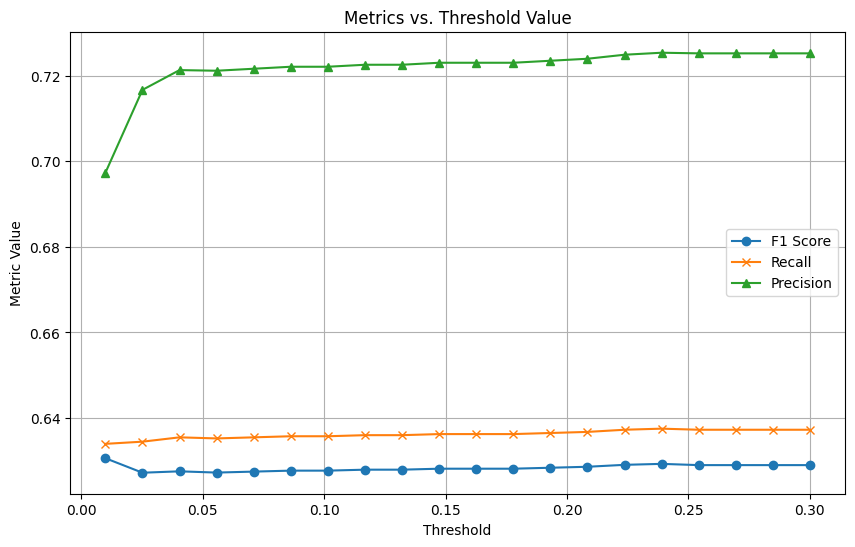

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

# Assuming you already have your `y_test` and `model_randomized` as in your code
# X_test should also be defined in your context
y_test = y_nucleus
thresholds = np.linspace(0.01, 0.3, 20)  # Vary threshold from 0.1 to 0.9 with 0.05 increments
f1_scores = []
recalls = []
precisions = []

for threshold in thresholds:
    y_test_pred = (class_probabilities[:, 1] >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_test_pred, average='weighted'))
    precisions.append(precision_score(y_test, y_test_pred, average='weighted'))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='x')
plt.plot(thresholds, precisions, label='Precision', marker='^')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Metrics vs. Threshold Value')
plt.legend()
plt.grid()

0.6375379939209727
0.6349408415647253
0.629184990396826


([<matplotlib.axis.YTick at 0x254f81a6850>,
 [Text(0, 0, 'M1'), Text(0, 1, 'M2')])

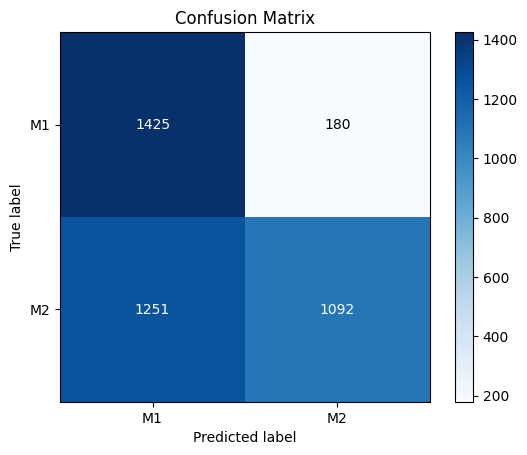

In [11]:
y_pred = class_probabilities[:,1] >= 0.4

accuracy = accuracy_score(y_nucleus, y_pred)
f1_macro = f1_score(y_nucleus, y_pred, average='macro')
f1_weighted = f1_score(y_nucleus, y_pred, average='weighted')
print(accuracy)
print(f1_macro)
print(f1_weighted)


skplt.metrics.plot_confusion_matrix(y_nucleus, y_pred, normalize=False, title='Confusion Matrix')
plt.xticks(range(2),['M1', 'M2'])
plt.yticks(range(2),['M1', 'M2'])

AUC:  0.7288163988177151


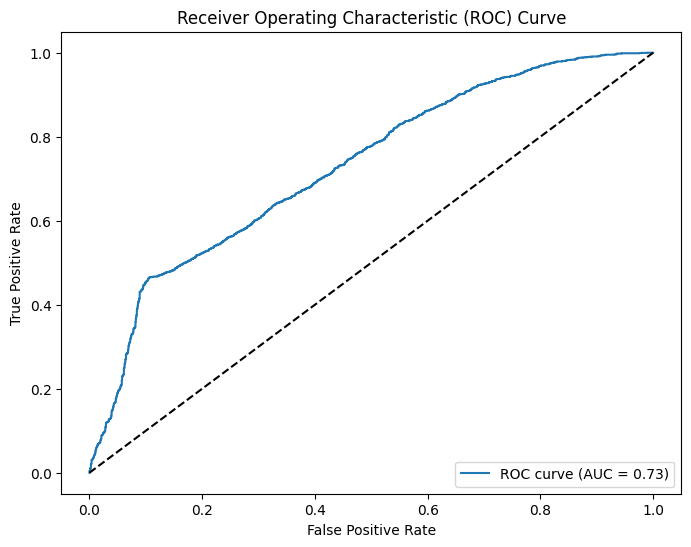

In [12]:
actual_labels = test_data[1]
predicted_probabilities = pipe.predict_proba(test_data[0])[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probabilities)

# Compute AUC
auc = roc_auc_score(actual_labels, predicted_probabilities)
print("AUC: ", auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Get the most important features

<Axes: ylabel='Feature'>

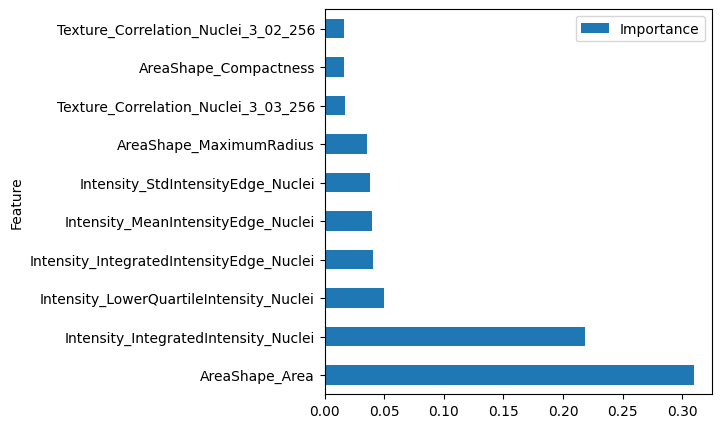

In [13]:
important_features_smooth = macrophages_analysis.get_best_features(pipe, all_surfaces.drop('CellType', axis=1), 10)
important_features_smooth.plot(x='Feature', y='Importance', kind='barh', figsize=(5, 5))   